# Assignment One

## Problem 1

This file contains code for problem 1.

In [24]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from IPython.display import Image

## Functions 

In [51]:
def pull_community(link):
    '''
    This function pulls in the community boundary area for Chicago.

    link: API link

    returns: dictionary with community number as key, community name as value
    '''

    response = requests.get(link)
    d = response.json()

    comm_dict = {}

    for comm in d:
        k = comm['area_num_1']
        l = comm['community']
        if k in comm_dict.keys():
            continue
        else:
            comm_dict[k] = l

    return comm_dict

    
def pull_data(api_link, inc = 50000):
    '''
    This function pulls data from the api_link and organizes it into a pandas dataframe.

    api_link: string containing api url
    inc: increment for data pull since api only returns (max) 50000 items at a time

    returns: dataframe
    '''

    off = 0

    full = []

    while True:
        url = f'{api_link}?$limit={inc}&$offset={off}'
        response = requests.get(url, timeout = 10)
        data = response.json()
        if data:
            full += data
            off += inc
        else: #empty response
            break

    return pd.DataFrame(full)

def num_crimes_type(*args):
    '''
    This function calculates the total number of crimes committed across all 
    dataframes inputted.

    *args: dataframes containing crime records (each row is a crime)

    return: integer with number of crimes
    '''

    all_years = []

    for df in args:
        yr = df['year'].unique()[0]
        #print(yr)
        by_type = df.groupby('primary_type').count()[['id']]
        by_type = by_type.reset_index()
        col_name = f'{yr} Total'
        by_type.columns = ['Type', col_name]
        all_years.append(by_type)

    if len(all_years) == 1:
        final_counts = all_years[0]
    elif len(all_years) == 2:
        final_counts = pd.merge(all_years[0], all_years[1], on = 'Type')
        col1 = final_counts.columns[1]
        col2 = final_counts.columns[2]
        final_counts['Percent Change'] = round((final_counts[col2]/final_counts[col1]-1)*100,1)

        #final_counts = final_counts.sort_values('Percent Change', ascending=False)
    else:
        final_counts = pd.merge(all_years[0], all_years[1], on = 'Type')
        for i in range(2, len(all_years)):
            final_counts = pd.merge(final_counts, all_years[i], on = 'Type')

    return final_counts


def mk_table(data, title, filename = 'table.png', dpi = 800):
    '''
    This function makes a matplotlib table from a pandas dataframe.

    data: pandas dataframe
    filename: filename to save table png
    dpi = resolution

    '''
    plt.figure(figsize=(8,6))
    plt.axis('off')

    cell_text = []
    for row in range(len(data)):
        cell_text.append(data.iloc[row])

    tab = plt.table(cellText=cell_text, 
        colLabels=data.columns, 
        loc='center')

    tab.auto_set_font_size(False)
    tab.set_fontsize(5)
        
    #plt.title(title)
    #plt.savefig(filename, dpi = 700)

def mk_bar(df, x_col, y_col, title, filename = 'bar.png', dpi = 500):
    '''
    This function makes a horizontal bar chart from a dataframe.

    df: dataframe
    x_col: name of column for the x-axis argument in the plot
    y_col: name of column for the y-axis argument in the plot
    filename: filename to save barchart png
    dpi = resolution

    return: None
    '''

    df = df.sort_values(y_col, ascending=True)
    df.plot.barh(x=x_col, y=y_col, legend = None)
    plt.title(title)
    plt.tick_params(axis='y', which='major', labelsize=3)
    plt.savefig(filename, bbox_inches='tight', dpi=400)

In [6]:
# Links to use

community_areas = 'https://data.cityofchicago.org/resource/igwz-8jzy.json'
crime_2017_api = 'https://data.cityofchicago.org/resource/d62x-nvdr.json'
crime_2018_api = 'https://data.cityofchicago.org/resource/3i3m-jwuy.json'

In [45]:
df1 = pull_data(crime_2017_api)
df2 = pull_data(crime_2018_api)

x = num_crimes_type(df1, df2)
x['Type']=x['Type'].str.capitalize()

In [49]:
x

,Type,2017 Total,2018 Total,Percent Change
0,Arson,444,372,-16.2
1,Assault,19303,20377,5.6
2,Battery,49214,49782,1.2
3,Burglary,13001,11729,-9.8
4,Concealed carry license violation,69,149,115.9
5,Crim sexual assault,1628,1627,-0.1
6,Criminal damage,29042,27806,-4.3
7,Criminal trespass,6812,6904,1.4
8,Deceptive practice,19028,18725,-1.6
9,Gambling,191,201,5.2


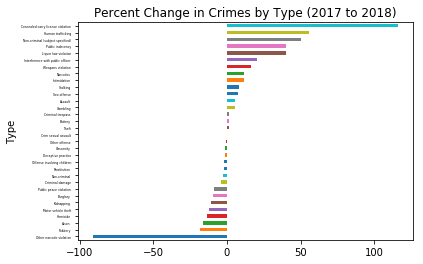

In [52]:
mk_bar(x, 'Type', 'Percent Change', 'Percent Change in Crimes by Type (2017 to 2018)', 'bar_type_chg.png')